<class 'pandas.core.frame.DataFrame'>
Index: 29130 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      29130 non-null  int64  
 1   LIMIT_BAL               29130 non-null  float64
 2   PAY_0                   26696 non-null  float64
 3   PAY_2                   26216 non-null  float64
 4   PAY_3                   25912 non-null  float64
 5   PAY_4                   25650 non-null  float64
 6   PAY_5                   25452 non-null  float64
 7   PAY_6                   25103 non-null  float64
 8   BILL_AMT1               29130 non-null  float64
 9   BILL_AMT2               29130 non-null  float64
 10  BILL_AMT3               29130 non-null  float64
 11  BILL_AMT4               29130 non-null  float64
 12  BILL_AMT5               29130 non-null  float64
 13  BILL_AMT6               29130 non-null  float64
 14  PAY_AMT1                29130 non-null  flo

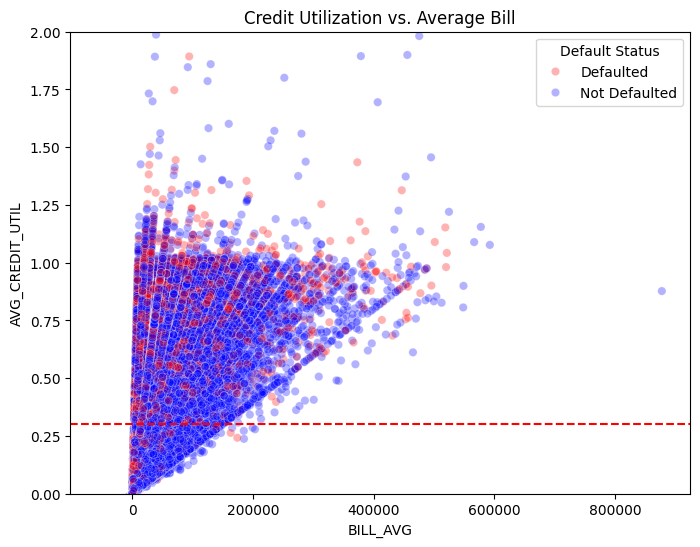

C:\Users\court\AppData\Local\Temp\ipykernel_10160\3302801197.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cc, x='Default Status', y='AVG_CREDIT_UTIL', palette={'Not Defaulted': 'blue', 'Defaulted': 'red'})


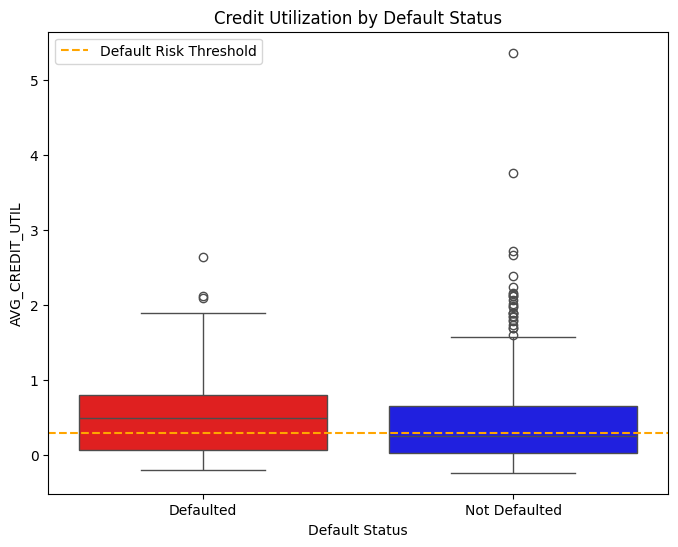

C:\Users\court\AppData\Local\Temp\ipykernel_10160\3302801197.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cc.groupby('util_band')['DEFAULT_PMT_NEXT_MONTH']



=== Logistic regression for Utilization 30-50% ===
Coefficients (beta): [-1.42539269  0.08267136 -0.3493113  -0.18720803]

Coefficients and odds ratios:
           feature      coef  odds_ratio
0        intercept -1.425393    0.240414
1  AVG_CREDIT_UTIL  0.082671    1.086185
2        LIMIT_BAL -0.349311    0.705174
3         BILL_AVG -0.187208    0.829271

Accuracy: 0.7827980402830702

Confusion matrix (rows = actual, cols = predicted):
[[2816   99]
 [ 699   60]]


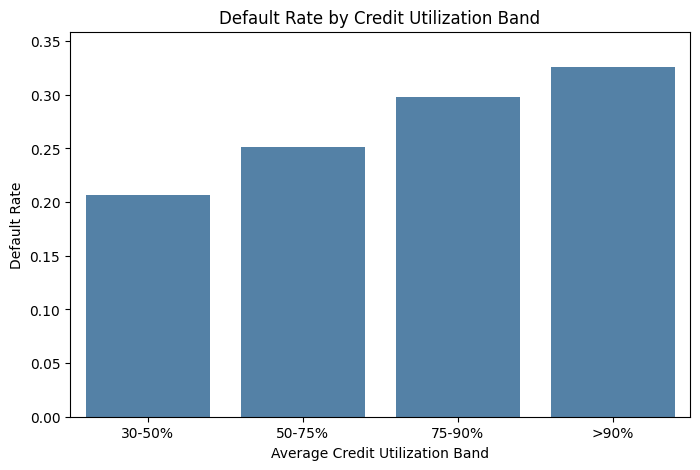

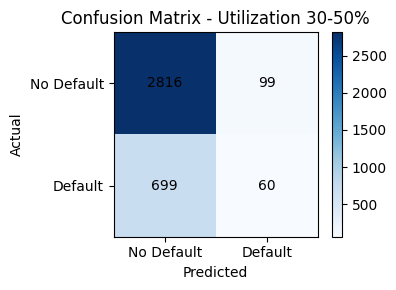


=== Logistic regression for Utilization 50-75% ===
Coefficients (beta): [-1.12334183  0.01515962 -0.13169277 -0.21525289]

Coefficients and odds ratios:
           feature      coef  odds_ratio
0        intercept -1.123342    0.325191
1  AVG_CREDIT_UTIL  0.015160    1.015275
2        LIMIT_BAL -0.131693    0.876610
3         BILL_AVG -0.215253    0.806338

Accuracy: 0.7054120541205412

Confusion matrix (rows = actual, cols = predicted):
[[3138  516]
 [ 921  303]]


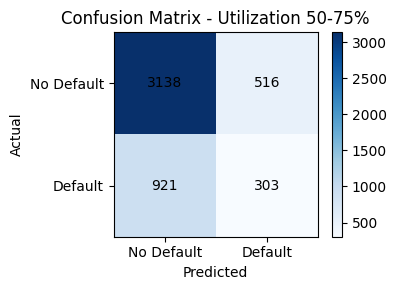


=== Logistic regression for Utilization 75-90% ===
Coefficients (beta): [-0.8687419   0.12892055 -0.17708437 -0.04304408]

Coefficients and odds ratios:
           feature      coef  odds_ratio
0        intercept -0.868742    0.419479
1  AVG_CREDIT_UTIL  0.128921    1.137600
2        LIMIT_BAL -0.177084    0.837709
3         BILL_AVG -0.043044    0.957869

Accuracy: 0.5332938739271974

Confusion matrix (rows = actual, cols = predicted):
[[1198 1173]
 [ 404  604]]


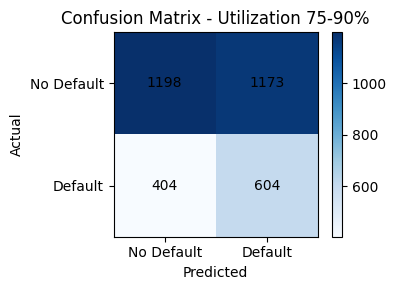


=== Logistic regression for Utilization >90% ===
Coefficients (beta): [-0.72687991 -0.05673906 -0.01277789 -0.05167611]

Coefficients and odds ratios:
           feature      coef  odds_ratio
0        intercept -0.726880    0.483415
1  AVG_CREDIT_UTIL -0.056739    0.944841
2        LIMIT_BAL -0.012778    0.987303
3         BILL_AVG -0.051676    0.949636

Accuracy: 0.3533190578158458

Confusion matrix (rows = actual, cols = predicted):
[[ 143 1745]
 [  67  847]]


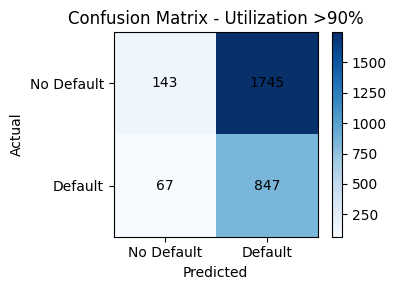

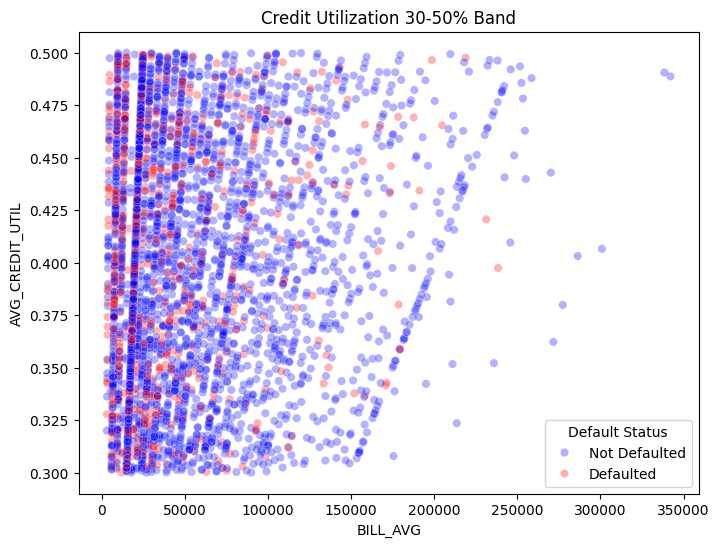

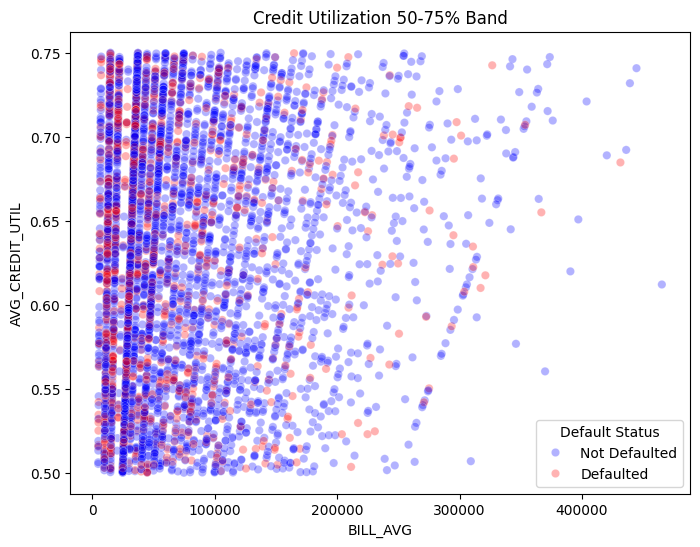

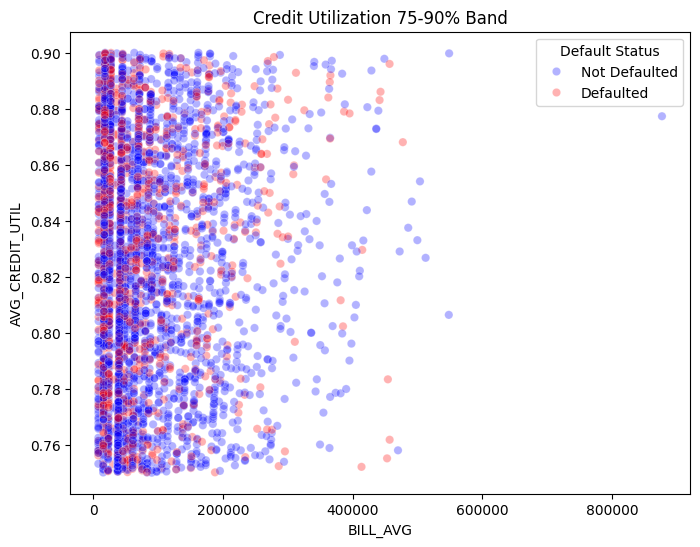

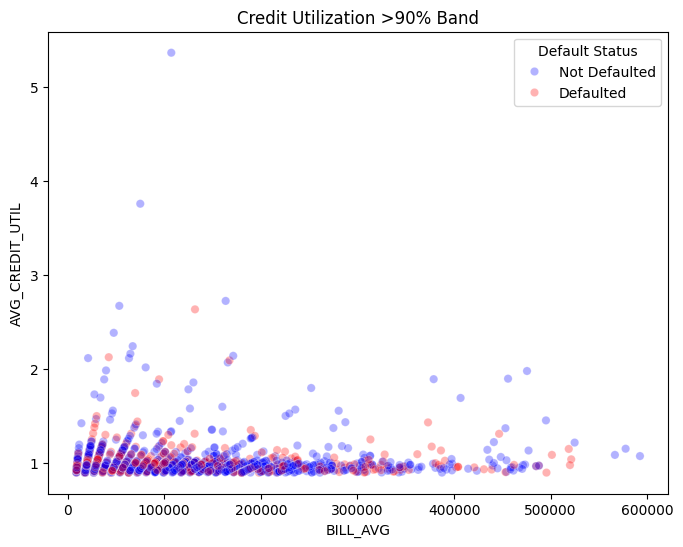

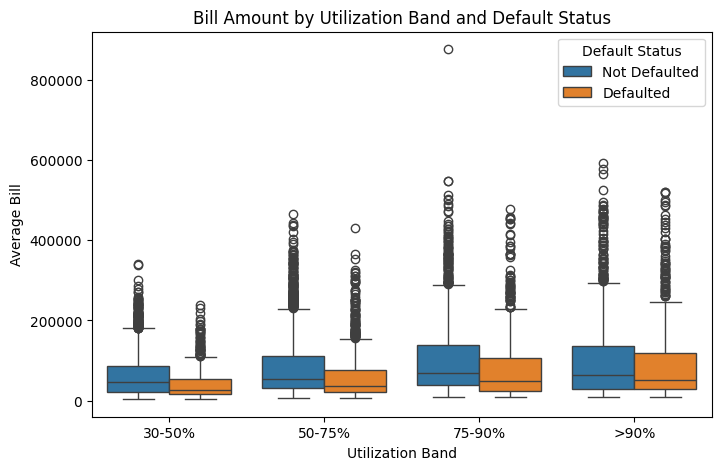

In [1]:
import pandas as pd
cc = pd.read_csv('UCI_Credit_Card.csv')

#Dropping demographics from the data set
cc.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE'], axis = 1, inplace = True)

#Renaming columns with a period to underscores for SQL compatability later
cc.rename(columns={'default.payment.next.month': 'DEFAULT_PMT_NEXT_MONTH'}, inplace=True)

#Next 3 lines of code is cleaning #s from 'e+05' to standard floats
cc['LIMIT_BAL'] = pd.to_numeric(cc['LIMIT_BAL'], errors='coerce')
cc['LIMIT_BAL'] = cc['LIMIT_BAL'].replace(',', '', regex=True).astype(float)

import numpy as np

#Replacing '-2' values in pay columns with NaN
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
cc[pay_cols] = cc[pay_cols].replace(-2, np.nan)

#Creating a column for the avg bill amount
cc['BILL_AVG'] = cc[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)

#Dropping the rows where bill avg = 0 (aka 0 debt)
cc = cc[cc['BILL_AVG'] != 0]

#Creating the average credit utilization
cc['AVG_CREDIT_UTIL'] = cc['BILL_AVG'] / cc['LIMIT_BAL']

#Converts those values to percentages
cc['AVG_CREDIT_UTIL_PCT'] = (cc['BILL_AVG'] / cc['LIMIT_BAL']) * 100

#Creating the database
import sqlite3
conn = sqlite3.connect('cc')

#Writing our cleaned data to the database - returns 29130 rows which is how many rows are in our cleaned dataset
cc.to_sql('my_table', conn, index=False, if_exists='replace')

#To see how much each customer owes and paid
query = """SELECT id, DEFAULT_PMT_NEXT_MONTH, SUM(BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6) AS AMT_OWED, SUM(PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6) AS AMT_PAYED
FROM my_table GROUP BY id, DEFAULT_PMT_NEXT_MONTH"""
sum_amts_owed_and_payed = pd.read_sql(query, conn)

#Identify High Credit Utilization Users who defaulted
query2 = """SELECT * FROM my_table WHERE (AVG_CREDIT_UTIL > 0.29) AND (DEFAULT_PMT_NEXT_MONTH == 1)"""
high_credit_util_and_default = pd.read_sql(query2, conn)

#Number of customers at risk of a default 
query3 = """SELECT COUNT(id) FROM my_table WHERE AVG_CREDIT_UTIL > 0.29"""
number_at_risk = pd.read_sql(query3, conn)
number_at_risk

#Total number of customers
query4 = """SELECT COUNT(id) FROM my_table"""
total_ids = pd.read_sql(query4, conn)
total_ids

#Percentage of customers at risk
pct_at_risk = (number_at_risk / total_ids) * 100
pct_at_risk

#Low risk customers
query5 = """SELECT id FROM my_table WHERE (AVG_CREDIT_UTIL > 0.29 AND AVG_CREDIT_UTIL < 0.50)"""
low_risk = pd.read_sql(query5, conn)
low_risk

#High risk customers
query6 = """SELECT id FROM my_table WHERE AVG_CREDIT_UTIL > 0.49"""
high_risk = pd.read_sql(query6, conn)
high_risk

#Identify 90+ Credit Utilization Users who defaulted
query7 = """SELECT * FROM my_table WHERE (AVG_CREDIT_UTIL > 0.89) AND (DEFAULT_PMT_NEXT_MONTH == 1)"""
high_default = pd.read_sql(query7, conn)
high_default

#Identify 75-89 Credit Utilization Users who defaulted
query8 = """SELECT * FROM my_table WHERE (AVG_CREDIT_UTIL > 0.74 AND AVG_CREDIT_UTIL < 0.90) AND (DEFAULT_PMT_NEXT_MONTH == 1)"""
moderate_default = pd.read_sql(query8, conn)
moderate_default

#Identify 50-74 Credit Utilization Users who defaulted
query9 = """SELECT * FROM my_table WHERE (AVG_CREDIT_UTIL > 0.49 AND AVG_CREDIT_UTIL < 0.75) AND (DEFAULT_PMT_NEXT_MONTH == 1)"""
low_default = pd.read_sql(query9, conn)
low_default

cc.info()
cc.describe()

#Import packages to help with data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Scatterplot to visualize the relationship between bill avg and default pmt next month with added hue on whether customer defaulted
cc['Default Status'] = cc['DEFAULT_PMT_NEXT_MONTH'].map({0: 'Not Defaulted', 1:'Defaulted'})
plt.figure(figsize=(8,6))
sns.scatterplot(data=cc, x='BILL_AVG', y='AVG_CREDIT_UTIL', hue='Default Status', palette={'Not Defaulted': 'blue', 'Defaulted': 'red'}, alpha=0.3)
plt.ylim([0,2])
plt.axhline(y=0.30, color='red', linestyle='--', label='Default Risk Threshold')
plt.title('Credit Utilization vs. Average Bill')
plt.show()

#Boxplot to visualize the statistics (median, min, max, 1st and 3rd quartile) among avg credit util and default status
cc['Default Status'] = cc['DEFAULT_PMT_NEXT_MONTH'].map({0: 'Not Defaulted', 1:'Defaulted'})
plt.figure(figsize=(8,6))
sns.boxplot(data=cc, x='Default Status', y='AVG_CREDIT_UTIL', palette={'Not Defaulted': 'blue', 'Defaulted': 'red'})
plt.axhline(y=0.3, color='orange', linestyle='--', label='Default Risk Threshold')
plt.title('Credit Utilization by Default Status')
plt.legend()
plt.show()

#Created utilization bands
cc['util_band'] = pd.cut(
    cc['AVG_CREDIT_UTIL'],
    bins=[0.3, 0.50, 0.75, 0.90, cc['AVG_CREDIT_UTIL'].max()],
    labels=['30-50%', '50-75%', '75-90%', '>90%'],
    include_lowest=True
)
#Computed default rate per band
band_summary = (
    cc.groupby('util_band')['DEFAULT_PMT_NEXT_MONTH']
      .mean()
      .reset_index()
      .rename(columns={'DEFAULT_PMT_NEXT_MONTH': 'default_rate'})
)
plt.figure(figsize=(8, 5))
sns.barplot(data=band_summary, x='util_band', y='default_rate', color='steelblue')
plt.ylabel('Default Rate')
plt.xlabel('Average Credit Utilization Band')
plt.ylim(0, band_summary['default_rate'].max() * 1.1)
plt.title('Default Rate by Credit Utilization Band')

#Running a logistic regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
 
def logistic_regression_gd(X, y, lr=0.01, n_iter=20000):
    """
    Fit logistic regression using gradient descent.
    X: (n_samples, n_features) with intercept column included
    y: (n_samples,) binary 0/1 array
    """
    n_samples, n_features = X.shape
    beta = np.zeros(n_features)
 
    for i in range(n_iter):
        z = X @ beta
        p = sigmoid(z)
        gradient = X.T @ (p - y) / n_samples
        beta -= lr * gradient
 
    return beta
def run_logit_on_subset(df, desc):
    print(f"\n=== Logistic regression for {desc} ===")
    y = df['DEFAULT_PMT_NEXT_MONTH'].values
    feature_cols = ['AVG_CREDIT_UTIL', 'LIMIT_BAL', 'BILL_AVG']
    X_raw = df[feature_cols].values

#Standardize within this subset
    X_mean = X_raw.mean(axis=0)
    X_std = X_raw.std(axis=0)
    X_scaled = (X_raw - X_mean) / X_std
    X = np.column_stack([np.ones(X_scaled.shape[0]), X_scaled])

#Fit
    beta = logistic_regression_gd(X, y, lr=0.01, n_iter=20000)
    print("Coefficients (beta):", beta)
    coef_names = ['intercept'] + feature_cols
    coef_df = pd.DataFrame({'feature': coef_names, 'coef': beta})
    coef_df['odds_ratio'] = np.exp(coef_df['coef'])
    print("\nCoefficients and odds ratios:")
    print(coef_df)

#Predict with a 0.3 threshold
    p_hat = sigmoid(X @ beta)
    y_pred = (p_hat >= 0.3).astype(int)
    accuracy = (y_pred == y).mean()
    print("\nAccuracy:", accuracy)
    tn = np.sum((y == 0) & (y_pred == 0))
    fp = np.sum((y == 0) & (y_pred == 1))
    fn = np.sum((y == 1) & (y_pred == 0))
    tp = np.sum((y == 1) & (y_pred == 1))
    cm = np.array([[tn, fp],
                   [fn, tp]])
    print("\nConfusion matrix (rows = actual, cols = predicted):")
    print(cm)

#Plotting the confusion matrix
    fig, ax = plt.subplots(figsize=(4, 3))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Default', 'Default'])
    ax.set_yticklabels(['No Default', 'Default'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {desc}')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                ha='center', va='center', color='black')
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

#30–50% band
subset_30_50 = cc[cc['util_band'] == '30-50%']
run_logit_on_subset(subset_30_50, 'Utilization 30-50%')

#50–75% band
subset_50_75 = cc[cc['util_band'] == '50-75%']
run_logit_on_subset(subset_50_75, 'Utilization 50-75%')

#75–90% band
subset_75_90 = cc[cc['util_band'] == '75-90%']
run_logit_on_subset(subset_75_90, 'Utilization 75-90%')

#>90% band
subset_90_plus = cc[cc['util_band'] == '>90%']
run_logit_on_subset(subset_90_plus, 'Utilization >90%')

#50–75% Utilization
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=subset_30_50, 
    x='BILL_AVG', 
    y='AVG_CREDIT_UTIL', 
    hue='Default Status', 
    palette={'Not Defaulted': 'blue', 'Defaulted': 'red'}, 
    alpha=0.3
)
plt.title('Credit Utilization 30-50% Band')
plt.show()

#50–75% Utilization
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=subset_50_75, 
    x='BILL_AVG', 
    y='AVG_CREDIT_UTIL', 
    hue='Default Status', 
    palette={'Not Defaulted': 'blue', 'Defaulted': 'red'}, 
    alpha=0.3
)
plt.title('Credit Utilization 50-75% Band')
plt.show()

#75–90% Utilization
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=subset_75_90, 
    x='BILL_AVG', 
    y='AVG_CREDIT_UTIL', 
    hue='Default Status', 
    palette={'Not Defaulted': 'blue', 'Defaulted': 'red'}, 
    alpha=0.3
)
plt.title('Credit Utilization 75-90% Band')
plt.show()

#>90% Utilization
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=subset_90_plus, 
    x='BILL_AVG', 
    y='AVG_CREDIT_UTIL', 
    hue='Default Status', 
    palette={'Not Defaulted': 'blue', 'Defaulted': 'red'}, 
    alpha=0.3
)
plt.title('Credit Utilization >90% Band')
plt.show()

#Barchart showing Average Bill and Utilization by band and if defaulted 
plt.figure(figsize=(8,5))
sns.boxplot(
    data=cc[cc['AVG_CREDIT_UTIL'] >= 0.3],
    x='util_band',
    y='BILL_AVG',
    hue='Default Status'
)
plt.ylabel('Average Bill')
plt.xlabel('Utilization Band')
plt.title('Bill Amount by Utilization Band and Default Status')
plt.show()